# Detailed Chemistry Modeling: Lime-Soda Softening Tutorial
*Integrating Reaktoro thermodynamics with WaterTAP process models*


---

## Tutorial Structure

| Part | Topic |
|------|-------|
| **1** | Problem Setup & Chemistry Background |
| **2** | Exploring Chemistry with Pure Reaktoro | 
| **3** | Integrating Reaktoro with WaterTAP |
| **4** | Optimization: Finding Minimum-Cost Dosing | 
| **5** | Final Step: Optimal Path on Operating Map |



---

## Part 1: Problem Setup

### 1.1 What Is Chemical Precipitation?

Chemical precipitation occurs when the **ionic activity product (IAP)** of certain ions exceeds a mineral’s **solubility product (Ksp)**:

$$
\text{IAP} = \prod_i a_i^{\nu_i},\qquad
\text{If IAP} > K_\text{sp},\ \text{mineral formation occurs.}
$$

### 1.2 Lime-Soda Softening Chemistry
Goal: precipitate calcium carbonate (calcite) to reduce water hardness.

**Reagent roles:**
- **Lime (CaO):** Raises pH → shifts carbonate equilibrium toward CO₃²⁻
- **Soda Ash (Na₂CO₃):** Provides carbonate ions for precipitation

**Key reactions:**
$$\text{CaO} + \text{H}_2\text{O} \rightarrow \text{Ca}^{2+} + 2\text{OH}^-$$
$$\text{Na}_2\text{CO}_3 \rightarrow 2\text{Na}^+ + \text{CO}_3^{2-}$$
$$\text{Ca}^{2+} + \text{CO}_3^{2-} \rightarrow \text{CaCO}_3(s)$$

**The tradeoff:** Lime adds calcium but raises pH. Soda ash provides carbonate but costs more. What's the optimal balance in lime and soda ash dosing?

### 1.3 Feed Water Composition

| Ion | Concentration (mg/L) |
|-----|---------------------|
| Na⁺ | 10,556 |
| K⁺ | 380 |
| Ca²⁺ | 400 |
| Mg²⁺ | 1,272 |
| Cl⁻ | 18,980 |
| SO₄²⁻ | 2,649 |
| HCO₃⁻ | 140 |


---

## Part 2: Exploring Chemistry with Pure Reaktoro

Before building complex process models, let's understand the chemistry using Reaktoro directly. This gives us fast, visual feedback on how lime and soda ash affect precipitation.

Reaktoro allows defining any number of aqueous species and solids from selected thermodynamic databases (e.g., PHREEQC, SUPCRT, EQ3/6).

### 2.1 Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import reaktoro

print(f"Reaktoro version: {reaktoro.__version__}")

Reaktoro version: 2.12.3


### 2.2 Define Feed Composition and System

In [36]:
# Feed composition (g/L)
feed_composition = {
    "Na": 10556e-3,
    "K": 380e-3,
    "Ca": 400e-3,
    "Mg": 1272e-3,
    "Cl": 18980e-3,
    "SO4": 2649e-3,
    "HCO3": 140e-3,
}

feed_pH = 7.9
temperature_C = 20
pressure_Pa = 101325

# Chemical costs ($/kg)
lime_cost = 0.25
soda_cost = 0.25

print("Feed composition loaded.")
print(f"Feed Ca: {feed_composition['Ca']*1000:.0f} mg/L")
print(f"Feed HCO3: {feed_composition['HCO3']*1000:.0f} mg/L")

Feed composition loaded.
Feed Ca: 400 mg/L
Feed HCO3: 140 mg/L


In [37]:
# Set up Reaktoro chemical system
db = reaktoro.PhreeqcDatabase("pitzer.dat")

solution = reaktoro.AqueousPhase(reaktoro.speciate("H O Na K Ca Mg Cl S C"))
solution.set(reaktoro.ActivityModelPitzer())

mineral = reaktoro.MineralPhase("Calcite")

system = reaktoro.ChemicalSystem(db, solution, mineral)

print(f"Chemical system created with {system.species().size()} species")

Chemical system created with 16 species


### 2.3 Build the Evaluation Function

This function takes lime and soda ash doses and returns:
- Ca removal efficiency
- Effluent pH
- Effluent alkalinity
- Reagent cost

In [38]:
def evaluate_softening(lime_dose_mg_L, soda_dose_mg_L, feed_comp, temp_C):
    """
    Evaluate lime-soda softening using Reaktoro equilibrium.

    Args:
        lime_dose_mg_L: Lime (CaO) dose in mg/L
        soda_dose_mg_L: Soda ash (Na2CO3) dose in mg/L
        feed_comp: Dict of feed concentrations in g/L
        temp_C: Temperature in Celsius

    Returns:
        Dict with results or None if equilibration fails
    """
    # Create chemical state
    state = reaktoro.ChemicalState(system)
    state.temperature(temp_C, "celsius")
    state.pressure(pressure_Pa, "Pa")

    # Add 1 kg of water (≈ 1 L basis)
    state.set("H2O", 1.0, "kg")

    # Add feed components (g/L → mol/L for 1 L basis)
    state.set("Na+", feed_comp["Na"] / 22.99, "mol")
    state.set("K+", feed_comp["K"] / 39.10, "mol")
    state.set("Ca+2", feed_comp["Ca"] / 40.08, "mol")
    state.set("Mg+2", feed_comp["Mg"] / 24.31, "mol")
    state.set("Cl-", feed_comp["Cl"] / 35.45, "mol")
    state.set("SO4-2", feed_comp["SO4"] / 96.06, "mol")
    state.set("HCO3-", feed_comp["HCO3"] / 61.02, "mol")

    # Add lime: CaO + H2O → Ca²⁺ + 2OH⁻
    lime_mol = lime_dose_mg_L * 1e-3 / 56.08  # mg/L → mol/L
    if lime_mol > 0:
        state.add("Ca+2", lime_mol, "mol")
        state.add("OH-", 2 * lime_mol, "mol")

    # Add soda ash: Na₂CO₃ → 2Na⁺ + CO₃²⁻
    soda_mol = soda_dose_mg_L * 1e-3 / 105.99  # mg/L → mol/L
    if soda_mol > 0:
        state.add("Na+", 2 * soda_mol, "mol")
        state.add("CO3-2", soda_mol, "mol")

    # Feed Ca for removal calculation
    feed_ca_mol = feed_comp["Ca"] / 40.08

    # Equilibrate
    solver = reaktoro.EquilibriumSolver(system)

    try:
        result = solver.solve(state)
        if not result.succeeded():
            return None

        # Extract results
        props = reaktoro.ChemicalProps(state)
        aqueous_props = reaktoro.AqueousProps(props)

        effluent_ca_mol = float(state.speciesAmount("Ca+2"))

        # Calcium removal % based on FEED Ca only
        ca_removal = 100 * (feed_ca_mol - effluent_ca_mol) / feed_ca_mol
        ca_removal = max(0, min(100, ca_removal))  # Clamp to 0-100%

        effluent_pH = float(aqueous_props.pH())
        alkalinity = (
            float(aqueous_props.alkalinity()) * 50.04 * 1000
        )  # eq/L → mg/L as CaCO₃
        calcite_mol = float(state.speciesAmount("Calcite"))

        # Cost ($/m³)
        cost = (
            lime_dose_mg_L * 1e-6 * lime_cost + soda_dose_mg_L * 1e-6 * soda_cost
        ) * 1000

        return {
            "ca_removal": ca_removal,
            "effluent_pH": effluent_pH,
            "alkalinity": alkalinity,
            "calcite_mol": calcite_mol,
            "cost": cost,
        }

    except Exception as e:
        return None

### 2.4 Test a Single Point

In [39]:
# Test with 100 mg/L lime and 200 mg/L soda ash
test = evaluate_softening(100, 200, feed_composition, temperature_C)

if test:
    print("Test evaluation at Lime=100 mg/L, Soda=200 mg/L:")
    print(f"  Ca removal:    {test['ca_removal']:.1f}%")
    print(f"  Effluent pH:   {test['effluent_pH']:.2f}")
    print(f"  Alkalinity:    {test['alkalinity']:.0f} mg/L as CaCO₃")
    print(f"  Cost:          ${test['cost']:.4f}/m³")
else:
    print("Equilibration failed!")

Test evaluation at Lime=100 mg/L, Soda=200 mg/L:
  Ca removal:    23.5%
  Effluent pH:   10.74
  Alkalinity:    34 mg/L as CaCO₃
  Cost:          $0.0750/m³


### 2.5 Parametric Sweep: Mapping the Operating Space

Now let's sweep across a range of lime and soda ash doses to see how they affect performance.

*This may take a few seconds to produce 25×25 grid results*

In [40]:
# Define sweep ranges
n_points = 25  # 25×25 = 625 evaluations

lime_range = np.linspace(0, 1200, n_points)  # mg/L
soda_range = np.linspace(0, 1200, n_points)  # mg/L

# Storage arrays
ca_removal_grid = np.zeros((n_points, n_points))
alkalinity_grid = np.zeros((n_points, n_points))
pH_grid = np.zeros((n_points, n_points))
cost_grid = np.zeros((n_points, n_points))

print(f"Running parametric sweep: {n_points}×{n_points} = {n_points**2} evaluations")
print(f"Lime range:  0 - {lime_range[-1]:.0f} mg/L")
print(f"Soda range:  0 - {soda_range[-1]:.0f} mg/L")

Running parametric sweep: 25×25 = 625 evaluations
Lime range:  0 - 1200 mg/L
Soda range:  0 - 1200 mg/L


In [41]:
# Run the sweep
failed_count = 0

for i, lime_dose in enumerate(lime_range):
    for j, soda_dose in enumerate(soda_range):
        result = evaluate_softening(
            lime_dose, soda_dose, feed_composition, temperature_C
        )

        if result is not None:
            ca_removal_grid[i, j] = result["ca_removal"]
            alkalinity_grid[i, j] = result["alkalinity"]
            pH_grid[i, j] = result["effluent_pH"]
            cost_grid[i, j] = result["cost"]
        else:
            ca_removal_grid[i, j] = np.nan
            alkalinity_grid[i, j] = np.nan
            pH_grid[i, j] = np.nan
            cost_grid[i, j] = np.nan
            failed_count += 1

    if (i + 1) % 5 == 0:
        print(f"  Progress: {100 * (i + 1) / n_points:.0f}%")

print(f"\n✓ Sweep complete. Failed: {failed_count}/{n_points**2}")

  Progress: 20%
  Progress: 40%
  Progress: 60%
  Progress: 80%
  Progress: 100%

✓ Sweep complete. Failed: 0/625


### 2.6 Visualize the Operating Space

These contour plots reveal the chemistry in terms of 
* Calcium removal efficiency
* Effluent alkalinity as CaCO3
* Effluent pH
* Reagent cost

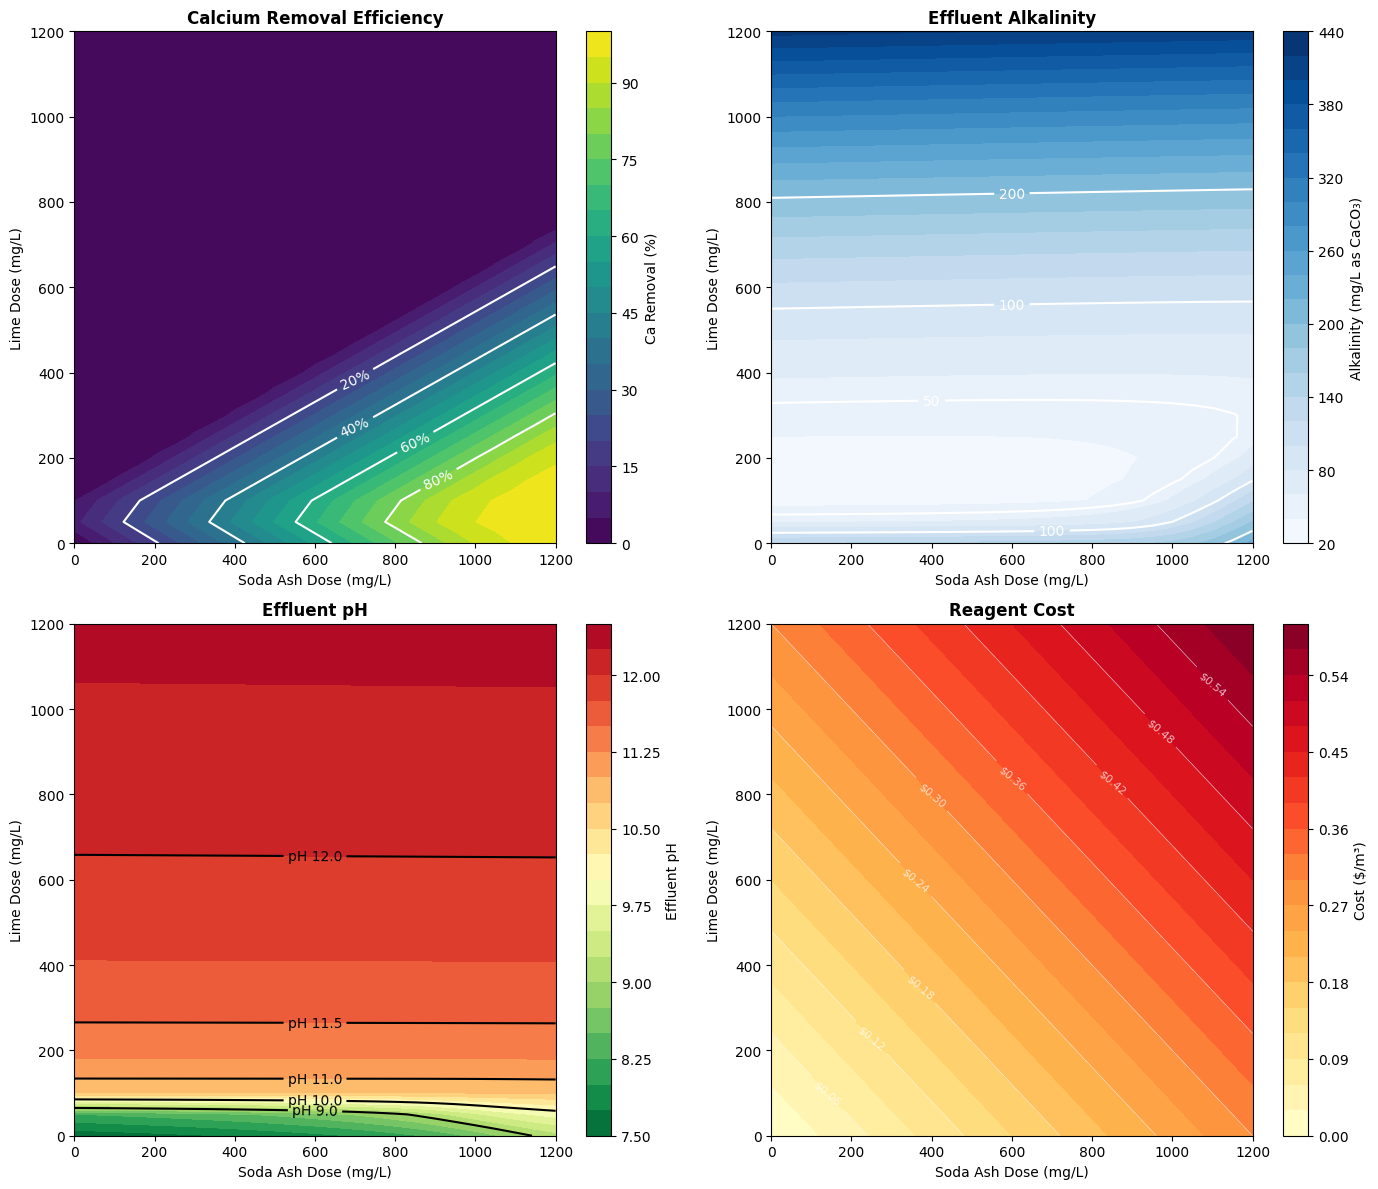


Figure saved to 'reaktoro_parametric_sweep.png'


In [42]:
# Create meshgrid for plotting
SODA, LIME = np.meshgrid(soda_range, lime_range)

# Create 2×2 contour plot
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Ca Removal Efficiency
ax1 = axes[0, 0]
cf1 = ax1.contourf(SODA, LIME, ca_removal_grid, levels=20, cmap="viridis")
cs1 = ax1.contour(
    SODA, LIME, ca_removal_grid, levels=[20, 40, 60, 80], colors="white", linewidths=1.5
)
ax1.clabel(cs1, inline=True, fontsize=10, fmt="%.0f%%")
plt.colorbar(cf1, ax=ax1, label="Ca Removal (%)")
ax1.set_xlabel("Soda Ash Dose (mg/L)")
ax1.set_ylabel("Lime Dose (mg/L)")
ax1.set_title("Calcium Removal Efficiency", fontweight="bold")

# Plot 2: Effluent Alkalinity
ax2 = axes[0, 1]
cf2 = ax2.contourf(SODA, LIME, alkalinity_grid, levels=20, cmap="Blues")
cs2 = ax2.contour(
    SODA,
    LIME,
    alkalinity_grid,
    levels=[50, 100, 200, 500],
    colors="white",
    linewidths=1.5,
)
ax2.clabel(cs2, inline=True, fontsize=10, fmt="%.0f")
plt.colorbar(cf2, ax=ax2, label="Alkalinity (mg/L as CaCO₃)")
ax2.set_xlabel("Soda Ash Dose (mg/L)")
ax2.set_ylabel("Lime Dose (mg/L)")
ax2.set_title("Effluent Alkalinity", fontweight="bold")

# Plot 3: Effluent pH
ax3 = axes[1, 0]
cf3 = ax3.contourf(SODA, LIME, pH_grid, levels=20, cmap="RdYlGn_r")
cs3 = ax3.contour(
    SODA, LIME, pH_grid, levels=[9, 10, 11, 11.5, 12], colors="black", linewidths=1.5
)
ax3.clabel(cs3, inline=True, fontsize=10, fmt="pH %.1f")
plt.colorbar(cf3, ax=ax3, label="Effluent pH")
ax3.set_xlabel("Soda Ash Dose (mg/L)")
ax3.set_ylabel("Lime Dose (mg/L)")
ax3.set_title("Effluent pH", fontweight="bold")

# Plot 4: Reagent Cost
ax4 = axes[1, 1]
cf4 = ax4.contourf(SODA, LIME, cost_grid, levels=20, cmap="YlOrRd")
cs4 = ax4.contour(
    SODA, LIME, cost_grid, levels=10, colors="white", linewidths=0.5, alpha=0.7
)
ax4.clabel(cs4, inline=True, fontsize=8, fmt="$%.2f")
plt.colorbar(cf4, ax=ax4, label="Cost ($/m³)")
ax4.set_xlabel("Soda Ash Dose (mg/L)")
ax4.set_ylabel("Lime Dose (mg/L)")
ax4.set_title("Reagent Cost", fontweight="bold")

plt.tight_layout()
plt.savefig("reaktoro_parametric_sweep.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nFigure saved to 'reaktoro_parametric_sweep.png'")

---

## Part 3: Integrating Reaktoro with WaterTAP

Pure Reaktoro is great for exploring chemistry, but for real process modeling we need:
- Mass and energy balances
- Multiple unit operations
- Techno-economic analysis

WaterTAP provides these capabilities. **[Reaktoro PSE](https://github.com/watertap-org/reaktoro-pse)** bridges Reaktoro with WaterTAP's Pyomo-based models.



### 3.1 Imports for WaterTAP Integration

In [43]:
## Import Pyomo components
from pyomo.environ import (
    Var,
    Param,
    Constraint,
    Expression,
    Objective,
    ConcreteModel,
    value,
    assert_optimal_termination,
    check_optimal_termination,
    units as pyunits,
)

# IDAES components
from idaes.core import FlowsheetBlock
from idaes.core.util.scaling import set_scaling_factor, constraint_scaling_transform
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.solvers import get_solver

# WaterTAP components
from watertap.property_models.multicomp_aq_sol_prop_pack import MCASParameterBlock
from watertap.unit_models.stoichiometric_reactor import StoichiometricReactor

# Import reaktoro-pse components
from reaktoro_pse.reaktoro_block import ReaktoroBlock
from reaktoro_pse.core.util_classes.cyipopt_solver import get_cyipopt_watertap_solver

### 3.2 Build the Stoichiometric Reactor Model

The `StoichiometricReactor` handles mass balances for reagent addition and precipitation. However, it requires us to specify how much precipitates — it cannot predict this on its own; i.e., it is an assumed-performance model.

In [44]:
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)
m.fs.properties = MCASParameterBlock(
    solute_list=["Na_+", "K_+", "Ca_2+", "Mg_2+", "Cl_-", "SO4_2-", "HCO3_-"]
)

m.fs.unit = StoichiometricReactor(
    property_package=m.fs.properties,
    precipitate={
        "Calcite": {
            "mw": 100.09 * pyunits.g / pyunits.mol,
            "precipitation_stoichiometric": {"Ca_2+": 1, "HCO3_-": 1},
        },
    },
    # Define reagents
    reagent={
        "Na2CO3": {
            "mw": 105.99 * pyunits.g / pyunits.mol,
            "dissolution_stoichiometric": {"Na_+": 2, "HCO3_-": 1},
        },
        "CaO": {
            "mw": 56.0774 * pyunits.g / pyunits.mol,
            "dissolution_stoichiometric": {"Ca_2+": 1, "H2O": 1},
        },
    },
)
print("StoichiometricReactor model built.")

2026-01-30 09:30:40 [WARNING] idaes.watertap.unit_models.stoichiometric_reactor: User did not specify density for reagent Na2CO3, using 1kg/L
2026-01-30 09:30:40 [WARNING] idaes.watertap.unit_models.stoichiometric_reactor: User did not specify density for reagent CaO, using 1kg/L
StoichiometricReactor model built.


### 3.3 Set Feed Conditions

In [45]:
# Set inlet state
m.fs.unit.dissolution_reactor.properties_in.calculate_state(
    var_args={
        ("flow_vol_phase", "Liq"): 1e-2,  # m³/s = 10 L/s
        ("conc_mass_phase_comp", ("Liq", "Na_+")): 10556 * pyunits.mg / pyunits.L,
        ("conc_mass_phase_comp", ("Liq", "K_+")): 380 * pyunits.mg / pyunits.L,
        ("conc_mass_phase_comp", ("Liq", "Ca_2+")): 400 * pyunits.mg / pyunits.L,
        ("conc_mass_phase_comp", ("Liq", "Mg_2+")): 1272 * pyunits.mg / pyunits.L,
        ("conc_mass_phase_comp", ("Liq", "Cl_-")): 18980 * pyunits.mg / pyunits.L,
        ("conc_mass_phase_comp", ("Liq", "SO4_2-")): 2649 * pyunits.mg / pyunits.L,
        ("conc_mass_phase_comp", ("Liq", "HCO3_-")): 140 * pyunits.mg / pyunits.L,
    },
    hold_state=True,
)

m.fs.unit.dissolution_reactor.properties_in[0].assert_electroneutrality(
    defined_state=True, adjust_by_ion="Cl_-"
)

m.fs.unit.inlet.pressure[0].fix(101325)
m.fs.unit.inlet.temperature[0].fix(273.15 + 20)

print("Feed conditions set.")

2026-01-30 09:30:40 [WARNING] idaes.watertap.property_models.multicomp_aq_sol_prop_pack: While using the calculate_state method on fs.unit.dissolution_reactor.properties_in[0.0], variable flow_vol_phase was provided as an argument in var_args, but it does not have a scaling factor. This suggests that the calculate_scaling_factor method has not been used or the variable was created on demand after the scaling factors were calculated. It is recommended to touch all relevant variables (i.e. call them or set an initial value) before using the calculate_scaling_factor method.
2026-01-30 09:30:40 [WARNING] idaes.watertap.property_models.multicomp_aq_sol_prop_pack: While using the calculate_state method on fs.unit.dissolution_reactor.properties_in[0.0], variable conc_mass_phase_comp was provided as an argument in var_args, but it does not have a scaling factor. This suggests that the calculate_scaling_factor method has not been used or the variable was created on demand after the scaling fact

### 3.4 Solve with Fixed Performance (Baseline)

First, solve with user-specified precipitation — this is without integrating with Reaktoro.

In [46]:
# Fix operating conditions (user must guess precipitate amount)
m.fs.unit.reagent_dose["Na2CO3"].fix(1e-3)  # kg/m³
m.fs.unit.reagent_dose["CaO"].fix(1e-3)  # kg/m³
m.fs.unit.flow_mass_precipitate["Calcite"].fix(1e-3)  # kg/s — THIS IS A GUESS!
m.fs.unit.waste_mass_frac_precipitate.fix(0.2)

assert degrees_of_freedom(m.fs.unit) == 0

# Initialize and solve
m.fs.unit.initialize()
solver = get_solver()
results = solver.solve(m.fs.unit, tee=False)
assert_optimal_termination(results)

print("\nBaseline solve with FIXED precipitate (not predicted)")
print(f"This is just mass balance accounting, not real chemistry.")

2026-01-30 09:30:41 [INFO] idaes.init.fs.unit.dissolution_reactor: Initialization Complete
2026-01-30 09:30:42 [INFO] idaes.init.fs.unit.precipitation_reactor: Initialization Complete
2026-01-30 09:30:42 [INFO] idaes.init.fs.unit.separator: Initialization Step 2 Complete: optimal - Optimal Solution Found
2026-01-30 09:30:43 [INFO] idaes.init.fs.unit: Initialization Complete: optimal - Optimal Solution Found

Baseline solve with FIXED precipitate (not predicted)
This is just mass balance accounting, not real chemistry.


### 3.5 Add Performance Metrics
* Calcium removal efficiency
* Bicarbonate removal efficiency

In [47]:
# Ca removal efficiency
m.fs.unit.ca_removal_efficiency = Expression(
    expr=100
    * (
        m.fs.unit.dissolution_reactor.properties_in[0].flow_mass_phase_comp[
            "Liq", "Ca_2+"
        ]
        - m.fs.unit.precipitation_reactor.properties_out[0].flow_mass_phase_comp[
            "Liq", "Ca_2+"
        ]
    )
    / m.fs.unit.dissolution_reactor.properties_in[0].flow_mass_phase_comp[
        "Liq", "Ca_2+"
    ]
)

# HCO3 removal efficiency
m.fs.unit.hco3_removal_efficiency = Expression(
    expr=100
    * (
        m.fs.unit.dissolution_reactor.properties_in[0].flow_mass_phase_comp[
            "Liq", "HCO3_-"
        ]
        - m.fs.unit.precipitation_reactor.properties_out[0].flow_mass_phase_comp[
            "Liq", "HCO3_-"
        ]
    )
    / m.fs.unit.dissolution_reactor.properties_in[0].flow_mass_phase_comp[
        "Liq", "HCO3_-"
    ]
)

print("Performance metrics added.")

Performance metrics added.


### 3.6 Add Reaktoro Chemistry Block

Now we integrate Reaktoro to **predict** precipitation instead of guessing it.

In [48]:
# Variables for Reaktoro interface
m.fs.unit.feed_pH = Var(initialize=7.9)
m.fs.unit.effluent_pH = Var(initialize=7, bounds=(5, 12), units=pyunits.dimensionless)
m.fs.unit.effluent_alkalinity = Var(
    initialize=100, units=pyunits.mg / pyunits.L, bounds=(0.1, None)
)

################## Reaktoro-PSE Interface (Inputs/Outputs) ###################
# Define Reaktoro Outputs
# Outputs from Reaktoro-PSE will be in moles because outputs come directly from Reaktoro
m.fs.unit.reaktoro_outputs = {
    ("speciesAmount", "Calcite"): m.fs.unit.flow_mol_precipitate["Calcite"],
    ("alkalinityAsCaCO3", None): m.fs.unit.effluent_alkalinity,
    ("pH", None): m.fs.unit.effluent_pH,
}

# Build the ReaktoroBlock
# For input, Pyomo vars can be convert to moles as needed
m.fs.unit.eq_precipitation = ReaktoroBlock(
    aqueous_phase={
        "composition": m.fs.unit.dissolution_reactor.properties_in[0].flow_mass_comp,
        "convert_to_rkt_species": True,  # Translate MCAS species' names to Reaktoro names
        "activity_model": reaktoro.ActivityModelPitzer(),
        "fixed_solvent_specie": "H2O",
    },
    system_state={
        "temperature": m.fs.unit.inlet.temperature[0],
        "pressure": m.fs.unit.inlet.pressure[0],
        "pH": m.fs.unit.feed_pH,
    },
    mineral_phase={"phase_components": ["Calcite"]},
    chemistry_modifier={
        "CaO": m.fs.unit.flow_mol_reagent["CaO"],
        "Na2CO3": m.fs.unit.flow_mol_reagent["Na2CO3"],
    },
    outputs=m.fs.unit.reaktoro_outputs,
    database_file="pitzer.dat",
    build_speciation_block=True,
)

print("ReaktoroBlock added — chemistry is now predictive.")

2026-01-30 09:30:43 [INFO] idaes.reaktoro_pse.core.reaktoro_inputs: Exact speciation is not provided! Fixing aqueous solvent and, excluding H
2026-01-30 09:30:43 [INFO] idaes.reaktoro_pse.core.reaktoro_inputs: Exact speciation is not provided! Fixing aqueous solvent and, excluding O
2026-01-30 09:30:43 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver inputs: ['[Cl]', '[C]', '[Na]', '[Mg]', '[S]', '[K]', '[Ca]', '[H2O]', '[H]', '[O]', '[H+]']
2026-01-30 09:30:43 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver constraints: ['charge', 'C_constraint', 'Na_constraint', 'Mg_constraint', 'S_constraint', 'K_constraint', 'Ca_constraint', 'H2O_constraint', 'H_dummy_constraint', 'O_dummy_constraint', 'pH']
2026-01-30 09:30:43 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver inputs: ['[H+]', '[H]', '[C]', '[O]', '[Na]', '[Mg]', '[S]', '[Cl]', '[K]', '[Ca]']
2026-01-30 09:30:43 [INFO] idaes.reaktoro_pse.core.reaktoro_solver: rktSolver constraints: ['charge', 'H_constrain

### 3.7 Solve with Chemistry-Predicted Precipitation

In [49]:
################## Fix Inputs and Model Scaling #############################
# Fix feed pH
m.fs.unit.feed_pH.fix(7.9)

# Switch to molar flow specification for reagents
m.fs.unit.flow_mol_reagent["Na2CO3"].fix(1e-2)  # mol/s
m.fs.unit.flow_mol_reagent["CaO"].fix(1e-2)  # mol/s
m.fs.unit.reagent_dose["Na2CO3"].unfix()
m.fs.unit.reagent_dose["CaO"].unfix()

# KEY STEP: Unfix precipitate — Reaktoro now determines it
m.fs.unit.flow_mass_precipitate["Calcite"].unfix()

# Reaktoro-PSE applies numerical scaling internally in the absence of user-defined scaling factors for inputs and outputs
# Initialize and solve
m.fs.unit.eq_precipitation.initialize()
print("Model Degrees of Freedom = " + str(degrees_of_freedom(m)))

solver = get_cyipopt_watertap_solver(max_iter=200, linear_solver="mumps", pivtol=1e-2)
result = solver.solve(m, tee=True)
assert_optimal_termination(result)

print("\nSolved with chemistry-predicted precipitation.")

2026-01-30 09:30:43 [INFO] idaes.reaktoro_pse.reaktoro_block: ---initializing property block fs.unit.eq_precipitation----
2026-01-30 09:30:43 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2026-01-30 09:30:43 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2026-01-30 09:30:43 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Initialized rkt block
Model Degrees of Freedom = 0
cyipopt-watertap: cyipopt with user variable scaling and IDAES jacobian constraint scaling

List of user-set options:

                                    Name   Value                used
              acceptable_constr_viol_tol = 1e-09                 yes
                 acceptable_dual_inf_tol = 0.01                  yes
                          acceptable_tol = 1e-09                 yes
                      bound_relax_factor = 0                     yes
                         constr_viol_tol = 1e-08                 yes
                  diverging_itera

In [50]:
print("\n" + "=" * 60)
print("RESULTS: Chemistry-Predicted Precipitation")
print("=" * 60)

print(f"\nReagent Doses:")
print(
    f"  Lime (CaO):        {value(pyunits.convert(m.fs.unit.reagent_dose['CaO'], to_units=pyunits.mg/pyunits.L)):.1f} mg/L"
)
print(
    f"  Soda Ash (Na2CO3): {value(pyunits.convert(m.fs.unit.reagent_dose['Na2CO3'], to_units=pyunits.mg/pyunits.L)):.1f} mg/L"
)

print(f"\nReaktoro-Integrated Predictions:")
print(f"  Effluent pH:       {value(m.fs.unit.effluent_pH):.2f}")
print(f"  Effluent Alk:      {value(m.fs.unit.effluent_alkalinity):.0f} mg/L as CaCO₃")

print(f"\nRemoval Performance:")
print(f"  Ca removal:        {value(m.fs.unit.ca_removal_efficiency):.1f}%")
print(f"  HCO3 removal:      {value(m.fs.unit.hco3_removal_efficiency):.1f}%")
print("=" * 60)


RESULTS: Chemistry-Predicted Precipitation

Reagent Doses:
  Lime (CaO):        56.1 mg/L
  Soda Ash (Na2CO3): 106.0 mg/L

Reaktoro-Integrated Predictions:
  Effluent pH:       8.58
  Effluent Alk:      31 mg/L as CaCO₃

Removal Performance:
  Ca removal:        20.0%
  HCO3 removal:      86.9%


---

## Part 4: Optimization — Finding Minimum-Cost Dosing

Now for the powerful part: instead of specifying doses and predicting removal, we flip the problem:

> **"I need X% calcium removal. What's the minimum-cost dosing strategy?"**

### 4.1 Set Up Optimization

In [51]:
# Reagent cost ($/m³ of feed)
m.fs.reagent_cost = Expression(
    expr=(
        m.fs.unit.flow_mol_reagent["CaO"] * 56.08e-3 * lime_cost
        + m.fs.unit.flow_mol_reagent["Na2CO3"] * 105.99e-3 * soda_cost
    )
    / m.fs.unit.dissolution_reactor.properties_in[0].flow_vol_phase["Liq"]
)

# Unfix reagent flows — these become decision variables
m.fs.unit.flow_mol_reagent["CaO"].unfix()
m.fs.unit.flow_mol_reagent["Na2CO3"].unfix()

# Set bounds
m.fs.unit.flow_mol_reagent["CaO"].setlb(1e-6)
m.fs.unit.flow_mol_reagent["CaO"].setub(10)
m.fs.unit.flow_mol_reagent["Na2CO3"].setlb(1e-5)
m.fs.unit.flow_mol_reagent["Na2CO3"].setub(10)

# Initialize at low doses
m.fs.unit.flow_mol_reagent["CaO"].set_value(1e-5)
m.fs.unit.flow_mol_reagent["Na2CO3"].set_value(1e-5)

# Minimum alkalinity constraint (operational requirement)
m.fs.minimum_alkalinity = Constraint(expr=m.fs.unit.effluent_alkalinity >= 50)

# Target removal constraint (mutable for parametric study)
m.fs.target_removal = Param(initialize=5, mutable=True)
m.fs.target_removal_con = Constraint(
    expr=m.fs.unit.ca_removal_efficiency >= m.fs.target_removal
)

# Objective: minimize cost
m.fs.objective = Objective(expr=m.fs.reagent_cost)
set_scaling_factor(m.fs.objective, 1e2)

print(f"Degrees of Freedom: {degrees_of_freedom(m)}")
print("Optimization problem set up.")

Degrees of Freedom: 2
Optimization problem set up.


### 4.2 Solve Across Range of Target Removals

*This may take a few seconds for 16 optimization solves*

In [52]:
results_list = []

print("\nOptimizing across removal targets...")
print("-" * 70)

for target in range(5, 85, 5):
    m.fs.target_removal.set_value(target)

    if target == 5:
        # Initialize at low doses for first solve
        m.fs.unit.reagent_dose["CaO"].set_value(0.1 * pyunits.mg / pyunits.L)
        m.fs.unit.reagent_dose["Na2CO3"].set_value(0.1 * pyunits.mg / pyunits.L)
        m.fs.unit.eq_precipitation.initialize()

    result = solver.solve(m, tee=False)

    if check_optimal_termination(result):
        results_list.append(
            {
                "target": target,
                "achieved": value(m.fs.unit.ca_removal_efficiency),
                "lime_dose": value(
                    pyunits.convert(
                        m.fs.unit.reagent_dose["CaO"], to_units=pyunits.mg / pyunits.L
                    )
                ),
                "soda_dose": value(
                    pyunits.convert(
                        m.fs.unit.reagent_dose["Na2CO3"],
                        to_units=pyunits.mg / pyunits.L,
                    )
                ),
                "pH": value(m.fs.unit.effluent_pH),
                "cost": value(m.fs.reagent_cost),
                "alkalinity": value(m.fs.unit.effluent_alkalinity),
            }
        )
        print(
            f"Target: {target:3d}% | Achieved: {results_list[-1]['achieved']:5.1f}% | "
            f"Lime: {results_list[-1]['lime_dose']:6.1f} mg/L | "
            f"Soda: {results_list[-1]['soda_dose']:6.1f} mg/L | "
            f"Cost: ${results_list[-1]['cost']:.4f}/m³"
        )
    else:
        print(f"Target: {target:3d}% | INFEASIBLE")

print("-" * 70)
print(f"\nCompleted {len(results_list)} optimizations")


Optimizing across removal targets...
----------------------------------------------------------------------
2026-01-30 09:30:44 [INFO] idaes.reaktoro_pse.reaktoro_block: ---initializing property block fs.unit.eq_precipitation----
2026-01-30 09:30:44 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2026-01-30 09:30:44 [INFO] idaes.reaktoro_pse.core.reaktoro_state: Equilibrated successfully
2026-01-30 09:30:44 [INFO] idaes.reaktoro_pse.core.reaktoro_block_builder: Initialized rkt block
Target:   5% | Achieved:   5.0% | Lime:   25.9 mg/L | Soda:    0.1 mg/L | Cost: $0.0065/m³
Target:  10% | Achieved:  10.0% | Lime:   50.5 mg/L | Soda:    9.8 mg/L | Cost: $0.0151/m³
Target:  15% | Achieved:  15.0% | Lime:   50.6 mg/L | Soda:   62.8 mg/L | Cost: $0.0284/m³
Target:  20% | Achieved:  20.0% | Lime:   50.7 mg/L | Soda:  115.9 mg/L | Cost: $0.0416/m³
Target:  25% | Achieved:  25.0% | Lime:   50.8 mg/L | Soda:  169.0 mg/L | Cost: $0.0549/m³
Target:  30% | Achieved:  30.0%

### 4.3 Plot Optimization Results

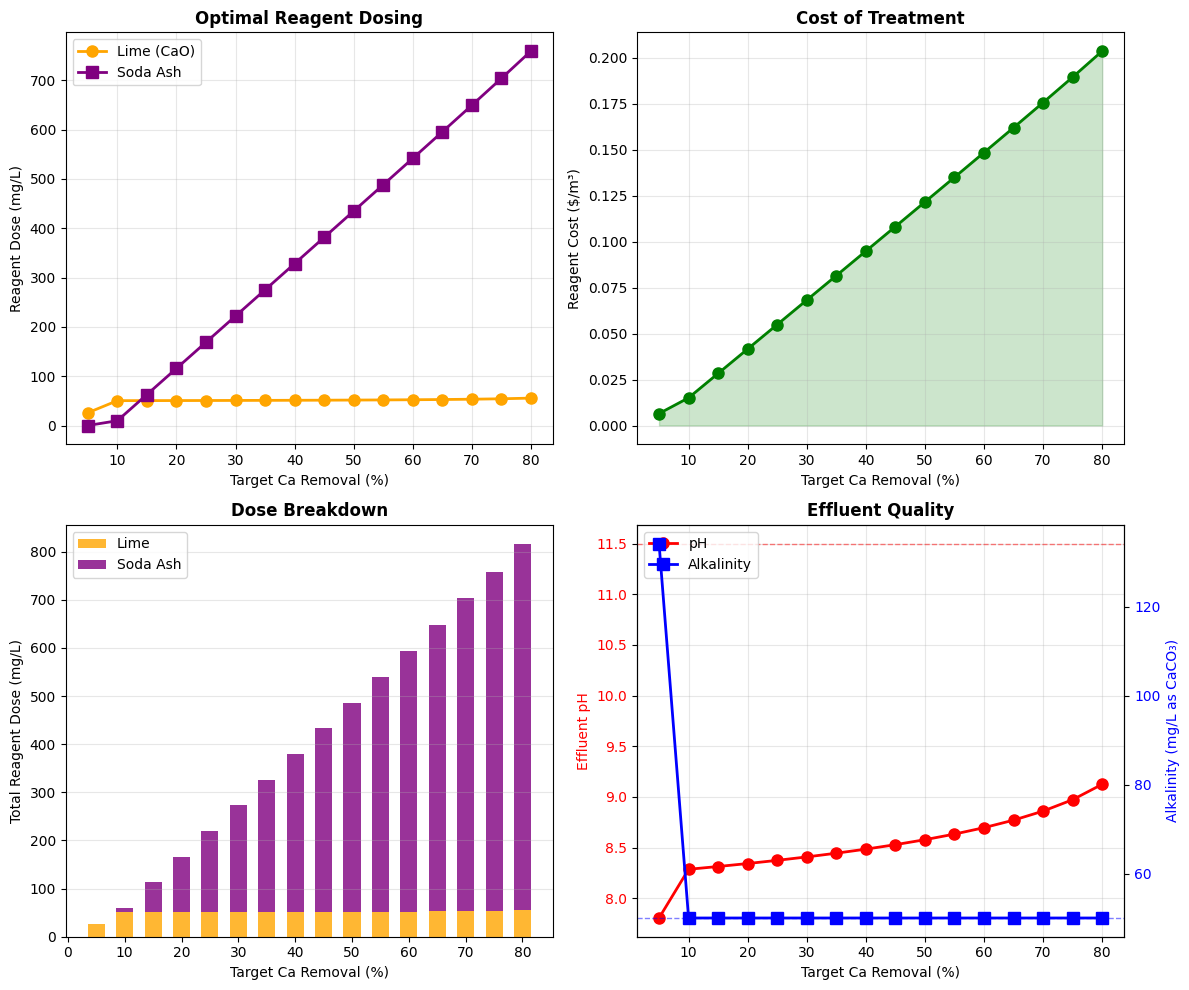


Figure saved to 'optimization_results.png'


In [53]:
# Extract results
targets = [r["target"] for r in results_list]
lime_doses = [r["lime_dose"] for r in results_list]
soda_doses = [r["soda_dose"] for r in results_list]
costs = [r["cost"] for r in results_list]
pHs = [r["pH"] for r in results_list]
alkalinities = [r["alkalinity"] for r in results_list]

# Create 2×2 plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Reagent doses
ax1 = axes[0, 0]
ax1.plot(
    targets,
    lime_doses,
    "o-",
    color="orange",
    linewidth=2,
    markersize=8,
    label="Lime (CaO)",
)
ax1.plot(
    targets,
    soda_doses,
    "s-",
    color="purple",
    linewidth=2,
    markersize=8,
    label="Soda Ash",
)
ax1.set_xlabel("Target Ca Removal (%)")
ax1.set_ylabel("Reagent Dose (mg/L)")
ax1.set_title("Optimal Reagent Dosing", fontweight="bold")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Cost
ax2 = axes[0, 1]
ax2.plot(targets, costs, "o-", color="green", linewidth=2, markersize=8)
ax2.fill_between(targets, costs, alpha=0.2, color="green")
ax2.set_xlabel("Target Ca Removal (%)")
ax2.set_ylabel("Reagent Cost ($/m³)")
ax2.set_title("Cost of Treatment", fontweight="bold")
ax2.grid(True, alpha=0.3)

# Plot 3: Stacked doses
ax3 = axes[1, 0]
ax3.bar(targets, lime_doses, width=3, label="Lime", color="orange", alpha=0.8)
ax3.bar(
    targets,
    soda_doses,
    width=3,
    bottom=lime_doses,
    label="Soda Ash",
    color="purple",
    alpha=0.8,
)
ax3.set_xlabel("Target Ca Removal (%)")
ax3.set_ylabel("Total Reagent Dose (mg/L)")
ax3.set_title("Dose Breakdown", fontweight="bold")
ax3.legend()
ax3.grid(True, alpha=0.3, axis="y")

# Plot 4: pH and Alkalinity
ax4 = axes[1, 1]
ax4_twin = ax4.twinx()

(line1,) = ax4.plot(
    targets, pHs, "o-", color="red", linewidth=2, markersize=8, label="Effluent pH"
)
ax4.axhline(y=11.5, color="red", linestyle="--", linewidth=1, alpha=0.5)
ax4.set_ylabel("Effluent pH", color="red")
ax4.tick_params(axis="y", labelcolor="red")

(line2,) = ax4_twin.plot(
    targets,
    alkalinities,
    "s-",
    color="blue",
    linewidth=2,
    markersize=8,
    label="Alkalinity",
)
ax4_twin.axhline(y=50, color="blue", linestyle="--", linewidth=1, alpha=0.5)
ax4_twin.set_ylabel("Alkalinity (mg/L as CaCO₃)", color="blue")
ax4_twin.tick_params(axis="y", labelcolor="blue")

ax4.set_xlabel("Target Ca Removal (%)")
ax4.set_title("Effluent Quality", fontweight="bold")
ax4.legend([line1, line2], ["pH", "Alkalinity"], loc="upper left")
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("optimization_results.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nFigure saved to 'optimization_results.png'")

---

## Part 5: Grand Finale — Optimal Path on Operating Map

Now let's overlay the optimal dosing path on our Reaktoro contour map. This shows how the optimizer navigates through the operating space to find minimum-cost solutions.

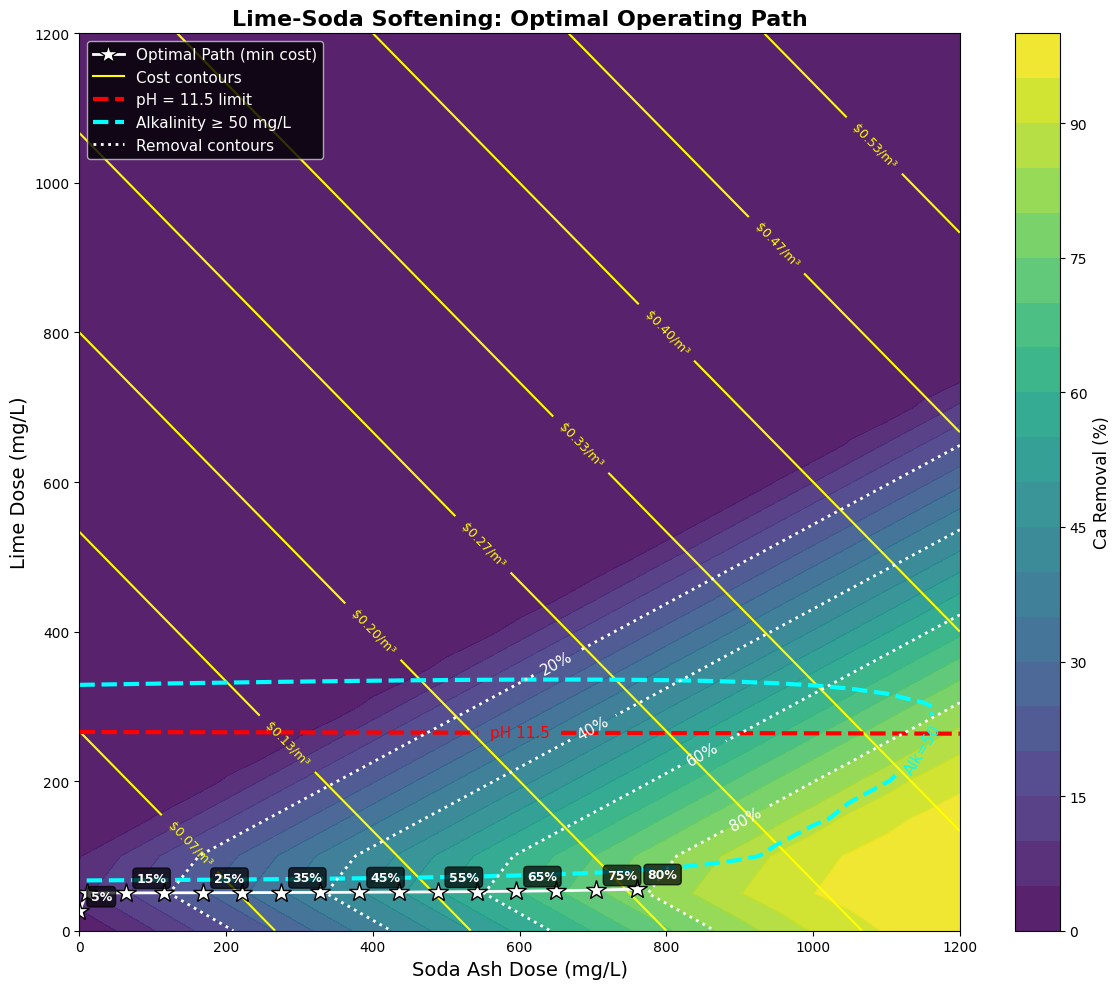


Figure saved to 'optimal_path_with_costs.png'


In [55]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(12, 10))

# Base: Ca removal contours
cf = ax.contourf(SODA, LIME, ca_removal_grid, levels=20, cmap="viridis", alpha=0.9)
cbar = plt.colorbar(cf, ax=ax)
cbar.set_label("Ca Removal (%)", fontsize=12)

# Overlay: Cost contours
cost_levels = np.linspace(
    cost_grid[~np.isnan(cost_grid)].min(), cost_grid[~np.isnan(cost_grid)].max(), 10
)
cs_cost = ax.contour(
    SODA,
    LIME,
    cost_grid,
    levels=cost_levels,
    colors="yellow",
    linewidths=1.5,
    linestyles="-",
)
ax.clabel(cs_cost, inline=True, fontsize=9, fmt="$%.2f/m³")

# Overlay: pH limit
cs_ph = ax.contour(
    SODA, LIME, pH_grid, levels=[11.5], colors="red", linewidths=3, linestyles="--"
)
ax.clabel(cs_ph, inline=True, fontsize=11, fmt="pH 11.5")

# Overlay: Alkalinity minimum
cs_alk = ax.contour(
    SODA,
    LIME,
    alkalinity_grid,
    levels=[50],
    colors="cyan",
    linewidths=3,
    linestyles="--",
)
ax.clabel(cs_alk, inline=True, fontsize=11, fmt="Alk=50")

# Overlay: Removal contours
cs_removal = ax.contour(
    SODA,
    LIME,
    ca_removal_grid,
    levels=[20, 40, 60, 80],
    colors="white",
    linewidths=2,
    linestyles=":",
)
ax.clabel(cs_removal, inline=True, fontsize=11, fmt="%.0f%%")

# THE OPTIMAL PATH
ax.plot(
    soda_doses,
    lime_doses,
    "*-",
    color="white",
    markersize=15,
    linewidth=2,
    markeredgecolor="black",
    markeredgewidth=1,
)

# Label points
for i, target in enumerate(targets):
    if (i % 2 == 0) or (i==len(targets)-1):  # Label every other point
        ax.annotate(
            f"{target}%",
            (soda_doses[i], lime_doses[i]),
            fontsize=9,
            color="white",
            fontweight="bold",
            xytext=(8, 8),
            textcoords="offset points",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="black", alpha=0.7),
        )

ax.set_xlabel("Soda Ash Dose (mg/L)", fontsize=14)
ax.set_ylabel("Lime Dose (mg/L)", fontsize=14)
ax.set_title(
    "Lime-Soda Softening: Optimal Operating Path", fontsize=16, fontweight="bold"
)

# Legend
legend_elements = [
    Line2D(
        [0],
        [0],
        color="white",
        linewidth=2,
        marker="*",
        markersize=15,
        markeredgecolor="black",
        label="Optimal Path (min cost)",
    ),
    Line2D([0], [0], color="yellow", linewidth=1.5, label="Cost contours"),
    Line2D([0], [0], color="red", linewidth=3, linestyle="--", label="pH = 11.5 limit"),
    Line2D(
        [0],
        [0],
        color="cyan",
        linewidth=3,
        linestyle="--",
        label="Alkalinity ≥ 50 mg/L",
    ),
    Line2D(
        [0], [0], color="white", linewidth=2, linestyle=":", label="Removal contours"
    ),
]
ax.legend(
    handles=legend_elements,
    loc="upper left",
    fontsize=11,
    facecolor="black",
    framealpha=0.8,
    labelcolor="white",
)

plt.tight_layout()
plt.savefig("optimal_path_with_costs.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nFigure saved to 'optimal_path_with_costs.png'")